In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_prepared.parquet')
dolly_cqa_df

,instruction,context,response,category,text,embeddings_mini_lm,embeddings_bge_large,fk_score,fk_score_categ
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"### CONTEXT ###\nVirgin Australia, the trading...","[0.07990753650665283, -0.04975801706314087, 0....","[0.5005730390548706, -0.46779343485832214, -1....",9.131896,easy
1,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,### CONTEXT ###\nKomorida was born in Kumamoto...,"[-0.011252421885728836, -0.04460098594427109, ...","[0.64762282371521, 0.43752172589302063, -0.047...",7.643152,easy
2,"Given a reference text about Lollapalooza, whe...",Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...,Lollapalooze is an annual musical festival hel...,closed_qa,### CONTEXT ###\nLollapalooza /ˌlɒləpəˈluːzə/ ...,"[0.06580415368080139, -0.0366082526743412, 0.0...","[0.5144393444061279, 0.18275967240333557, -0.4...",11.617224,medium
3,Who was Kyle Van Zyl playing against when he s...,Van Zyl joined the Eastern Province Kings Acad...,Kyle Van Zyl was playing against Boland U21 wh...,closed_qa,### CONTEXT ###\nVan Zyl joined the Eastern Pr...,"[0.019957538694143295, 0.04702803120017052, -0...","[1.1888214349746704, 0.058644916862249374, -0....",11.474969,medium
4,Who was the first to record the Needles and Pi...,"""Needles and Pins"" is a rock song credited to ...",The first artist to record Needles and Pins so...,closed_qa,"### CONTEXT ###\n""Needles and Pins"" is a rock ...","[-0.08916875720024109, 0.0042908587493002415, ...","[-0.08973768353462219, -0.17643515765666962, 0...",9.573611,easy
...,...,...,...,...,...,...,...,...,...
1456,How many world championships has Max Verstappe...,"After winning the 2021 Abu Dhabi Grand Prix, V...",Max Verstappen has won 2 Formula One World Cha...,closed_qa,### CONTEXT ###\nAfter winning the 2021 Abu Dh...,"[0.044786978513002396, 0.0190593209117651, -0....","[0.5898312330245972, 0.14761556684970856, -0.4...",7.991569,easy
1457,What is the history of coffee?,The history of coffee dates back to centuries ...,Much of the early history of coffee was tied t...,closed_qa,### CONTEXT ###\nThe history of coffee dates b...,"[0.019176138564944267, 0.02772548422217369, -0...","[0.10451232641935349, 0.22819367051124573, -0....",11.447779,medium
1458,What are common florals found in Zigalga Natio...,Zigalga National Park (Russian: Национальный п...,Zigalga National Park has the majority of its ...,closed_qa,### CONTEXT ###\nZigalga National Park (Russia...,"[-0.026473581790924072, 0.09908297657966614, -...","[0.1897222250699997, 0.41683098673820496, 0.02...",12.950833,medium
1459,What is linux Bootloader,"A bootloader, also spelled as boot loader or c...",A bootloader is a program written in machine c...,closed_qa,"### CONTEXT ###\nA bootloader, also spelled as...","[-0.05690043047070503, 0.05346180498600006, -0...","[0.32251039147377014, -0.2482924461364746, 0.0...",19.799659,hard


In [3]:
def train_linear_regression_with_cv(df, embeddings_col, y_col):
    X = np.array(df[embeddings_col].tolist())
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col].values
    
    kf = KFold(n_splits=7, shuffle=True, random_state=369)
    
    best_model = None
    best_error = float('inf')
    
    for train_index, val_index in kf.split(df):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_val)
        error = mean_squared_error(y_val, predictions)
        
        if error < best_error:
            best_error = error
            best_model = model
    
    return best_model

In [4]:
clf = train_linear_regression_with_cv(df=dolly_cqa_df, embeddings_col='embeddings_mini_lm', y_col='fk_score')

In [5]:
def get_predictions(df, clf, embeddings_col, y_col):
    X = np.array(df[embeddings_col].tolist())
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    
    y = df[y_col].values

    y_pred = clf.predict(X)

    print('MSE:', mean_squared_error(y, y_pred))
    print('MAE:', mean_absolute_error(y, y_pred))
    print('R2:', r2_score(y, y_pred))

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y, y=y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

MSE: 3.636588083024375
MAE: 1.4695096306122626
R2: 0.5548973514213369


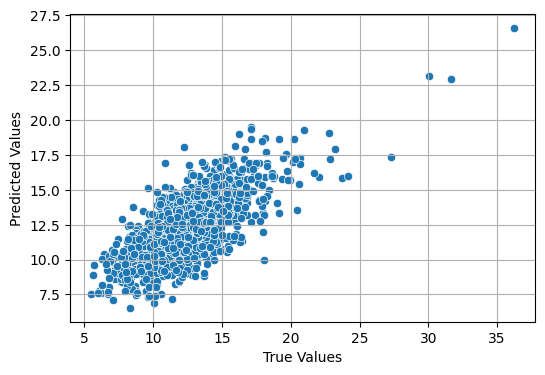

In [6]:
get_predictions(df=dolly_cqa_df, clf=clf, embeddings_col='embeddings_mini_lm', y_col='fk_score')

In [7]:
# dolly_cqa_df['score_easy'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,0]
# dolly_cqa_df['score_hard'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,1]
# dolly_cqa_df['score_medium'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_bge_large'].tolist()))[:,2]

# dolly_cqa_df['w_easy_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[0])
# dolly_cqa_df['w_hard_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[1])
# dolly_cqa_df['w_medium_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x * clf.coef_[2])
# dolly_cqa_df['iw_easy_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[0])
# dolly_cqa_df['iw_hard_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[1])
# dolly_cqa_df['iw_medium_embeddings'] = dolly_cqa_df['embeddings_bge_large'].apply(lambda x: x / clf.coef_[2])

dolly_cqa_df['score'] = clf.predict(X=np.array(dolly_cqa_df['embeddings_mini_lm'].tolist()))
dolly_cqa_df['absolute_error'] = np.abs(np.array(dolly_cqa_df['fk_score']) - clf.predict(X=np.array(dolly_cqa_df['embeddings_mini_lm'].tolist())))
dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_)
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_)

In [8]:
def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column=score_col, aggfunc='mean'), 
        score_std =pd.NamedAgg(column=score_col, aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 20
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

dolly_cqa_df['uw_kmeans'] = uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = iw_kmeans.labels_

# cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
# cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
# cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

In [9]:
cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score', 'absolute_error']]
cluster_df = pd.melt(cluster_df, id_vars=['score', 'absolute_error'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(['weighting', 'cluster_id']).agg({'score': ['mean', 'var'], 'absolute_error': ['mean', 'var']}).reset_index()
cluster_df.columns = ['weighting', 'cluster_id', 'mean_score', 'var_score', 'mean_absolute_error', 'var_absolute_error']

In [10]:
cluster_df

,weighting,cluster_id,mean_score,var_score,mean_absolute_error,var_absolute_error
0,iw_kmeans,0,12.030935,4.869932,1.353480,1.366681
1,iw_kmeans,1,12.529469,3.910327,1.467462,1.262236
2,iw_kmeans,2,12.023586,4.907327,1.294828,1.387511
3,iw_kmeans,3,11.749701,5.080947,1.519144,1.926069
4,iw_kmeans,4,11.528015,4.328936,1.484119,1.073862
5,iw_kmeans,5,12.030542,3.974937,1.264814,1.018395
6,iw_kmeans,6,12.965711,7.355379,1.633097,2.003920
7,iw_kmeans,7,11.595182,3.845937,1.502395,1.174996
8,iw_kmeans,8,12.470333,4.712738,1.329361,0.862250
9,iw_kmeans,9,11.598883,3.955570,1.343886,1.568945


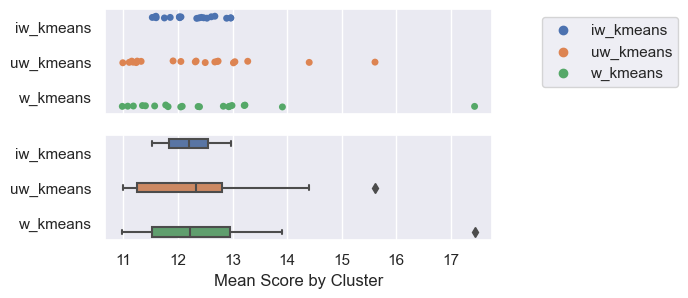

In [11]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Score by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

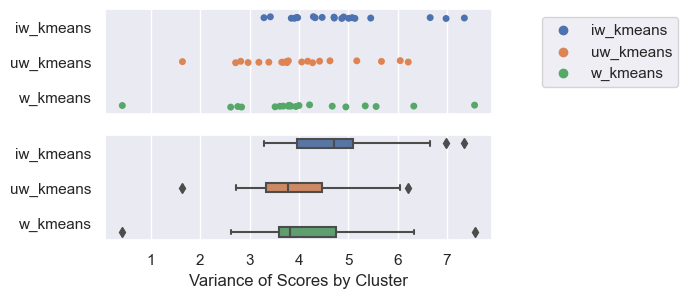

In [12]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Scores by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

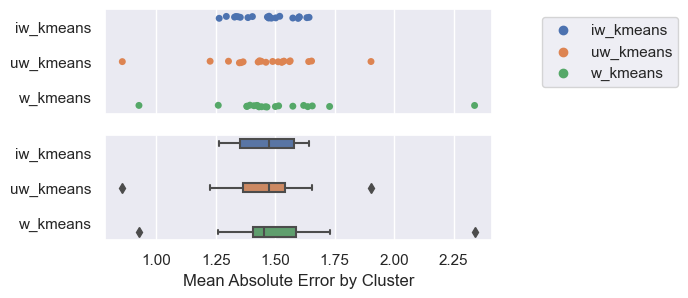

In [13]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_absolute_error', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_absolute_error', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Absolute Error by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

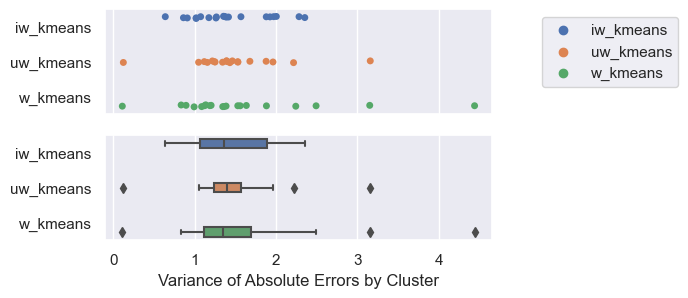

In [14]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_absolute_error', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_absolute_error', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Absolute Errors by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

In [15]:
def plot_cluster_scores(df):
  
    cluster_columns = ['uw_kmeans', 'w_kmeans', 'iw_kmeans']
    
    # Set up the matplotlib figure
    num_clusters = len(cluster_columns)
    fig, axs = plt.subplots(num_clusters, 1, figsize=(8, 4*num_clusters))
    
    for i, cluster_column in enumerate(cluster_columns):
        ax = axs[i]
        sns.countplot(data=df, x=cluster_column, hue='fk_score_categ', ax=ax)
        ax.set_title(f'Score Counts by {cluster_column}')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

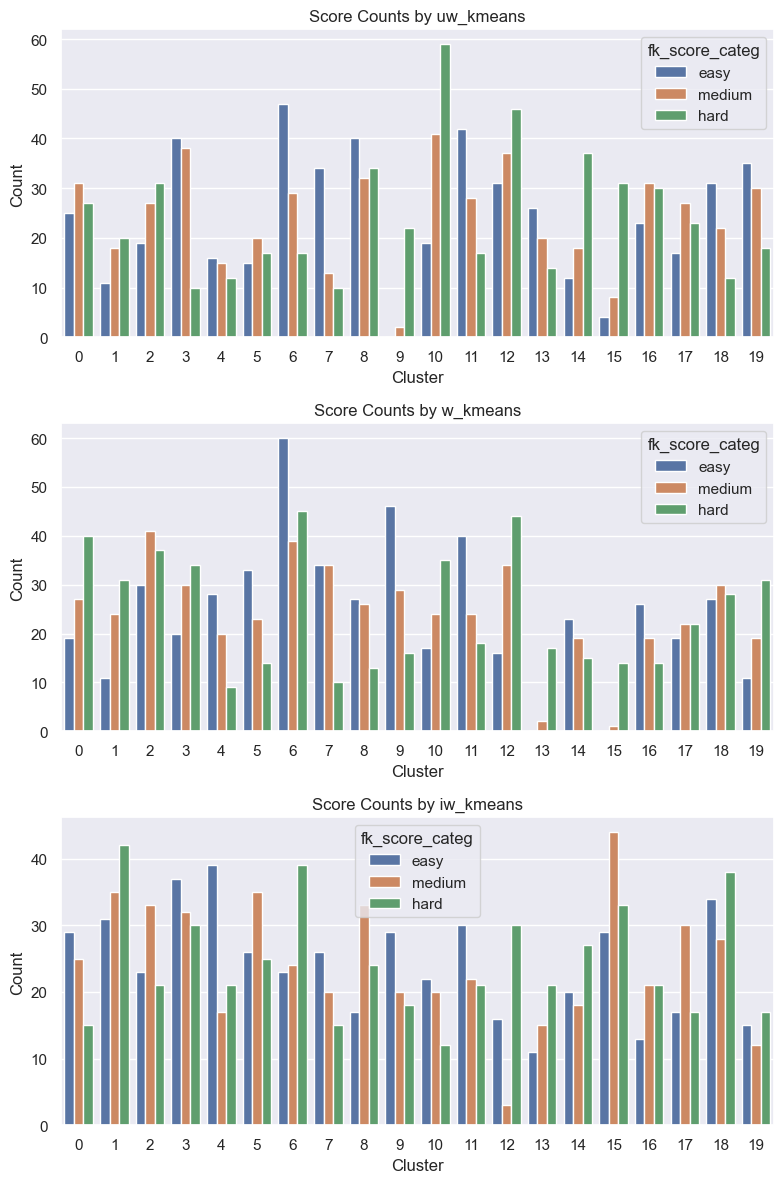

In [16]:
plot_cluster_scores(dolly_cqa_df)

<AxesSubplot:>

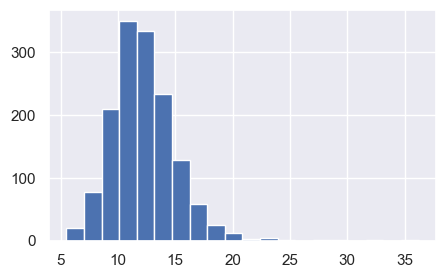

In [17]:
dolly_cqa_df['fk_score'].hist(bins=20)

In [18]:
len(dolly_cqa_df[dolly_cqa_df['fk_score'] <= 7])

20

In [19]:
aspect_embedding = np.mean(dolly_cqa_df[dolly_cqa_df['fk_score'] <= 7]['embeddings_mini_lm'])

aspect_embedding = aspect_embedding / np.linalg.norm(aspect_embedding)

dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm']
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm']

alpha = 1.75
for i, embedding in enumerate(dolly_cqa_df['embeddings_mini_lm']):
    embedding = embedding / np.linalg.norm(embedding)
    projection = np.dot(embedding, aspect_embedding.T) * aspect_embedding
    projection = projection.reshape(-1,)
    dolly_cqa_df['w_embeddings'].iloc[i] = embedding + alpha * projection
    dolly_cqa_df['iw_embeddings'].iloc[i] = embedding - alpha * projection


In [20]:
n_clusters = 20
seed=0
uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

dolly_cqa_df['uw_kmeans'] = uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = iw_kmeans.labels_

cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score', 'absolute_error']]
cluster_df = pd.melt(cluster_df, id_vars=['score', 'absolute_error'], var_name='weighting', value_name='cluster_id')
cluster_df = cluster_df.groupby(['weighting', 'cluster_id']).agg({'score': ['mean', 'var'], 'absolute_error': ['mean', 'var']}).reset_index()
cluster_df.columns = ['weighting', 'cluster_id', 'mean_score', 'var_score', 'mean_absolute_error', 'var_absolute_error']

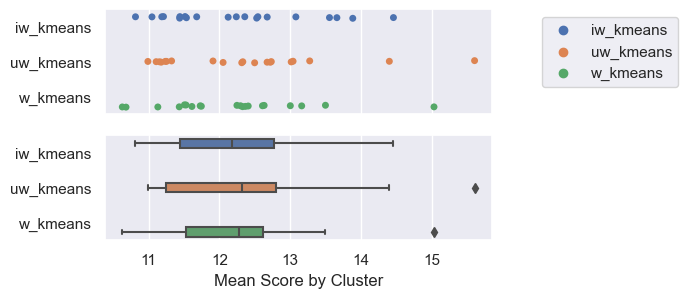

In [21]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='mean_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='mean_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Mean Score by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

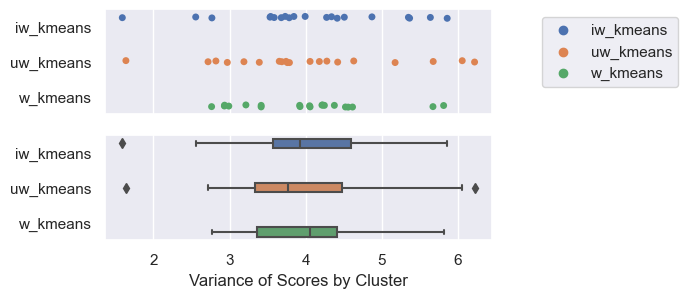

In [22]:
sns.set(rc={"figure.figsize":(5, 3)})
fig, axes = plt.subplots(2, 1, sharey=True)

sns.stripplot(x='var_score', y='weighting', data=cluster_df, jitter=True, hue='weighting', dodge=True, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axes[0].set(ylabel=None)
axes[0].set(xticklabels=[])
axes[0].set(xlabel=None)

sns.boxplot(x='var_score', y ='weighting', data=cluster_df, hue='weighting', dodge=True, ax=axes[1])
axes[1].set(ylabel=None)
axes[1].set(xlabel='Variance of Scores by Cluster')
axes[1].legend([], [], frameon=False)

plt.show()

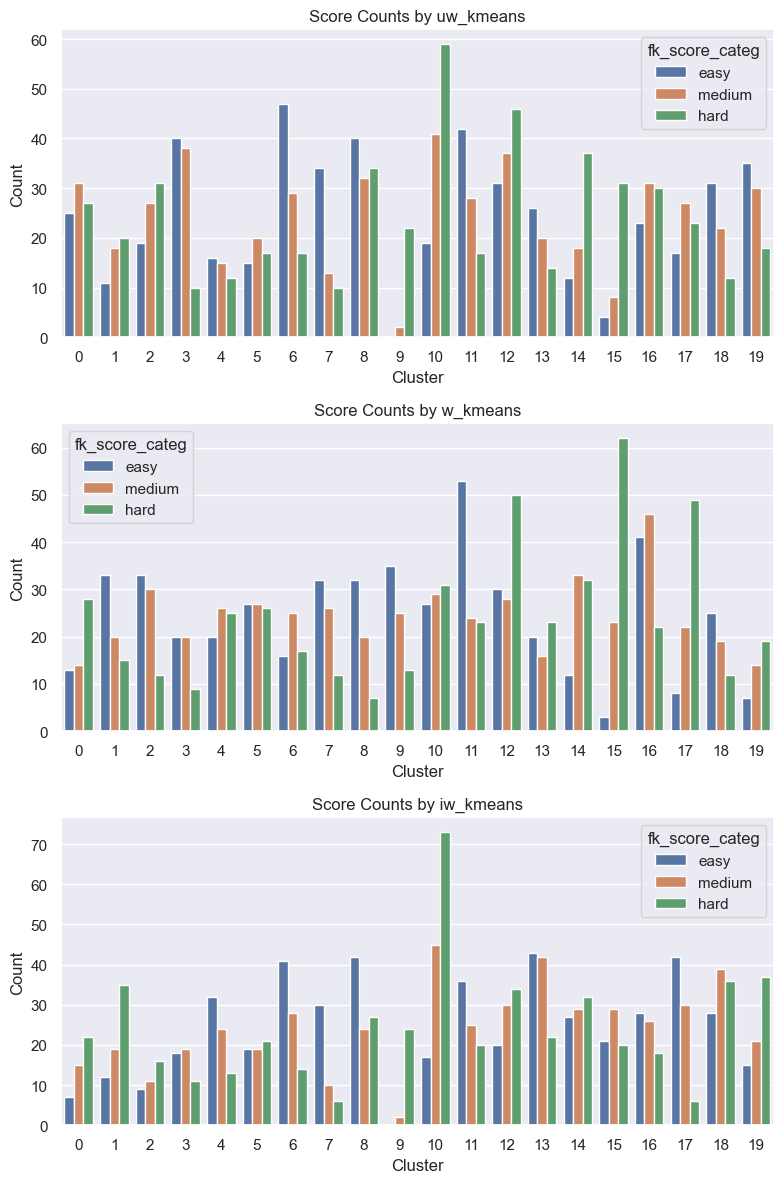

In [23]:
plot_cluster_scores(dolly_cqa_df)